In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns
import random
import time
import collections
from tqdm import tqdm
from tensor2tensor.utils import beam_search
sns.set()

/usr/local/lib/python3.6/dist-packages/tensorflow/python/util/tf_inspect.py:75: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  return _inspect.getargspec(target)
/usr/local/lib/python3.6/dist-packages/tensorflow/python/util/tf_inspect.py:75: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  return _inspect.getargspec(target)
/usr/local/lib/python3.6/dist-packages/tensorflow/python/util/tf_inspect.py:75: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  return _inspect.getargspec(target)
/usr/local/lib/python3.6/dist-packages/tensorflow/python/util/tf_inspect.py:75: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  return _inspect.getargspec(target)
/usr/local/lib/python3.6/dist-pa

In [2]:
with open('shakespeare.txt') as fopen:
    shakespeare = fopen.read()

In [3]:
char2idx = {c: i+3 for i, c in enumerate(set(shakespeare))}
char2idx['<pad>'] = 0
char2idx['<start>'] = 1
char2idx['<end>'] = 2

In [4]:
idx2char = {v:k for k, v in char2idx.items()}

In [5]:
batch_size = 32
sequence_length = 1000
step = 25

In [6]:
X = [char2idx[char] for char in list(shakespeare)]
len(X)

1115394

In [7]:
len_win = sequence_length
sequences = []
for i in range(0, len(X) - len_win, step):
    clip = X[i: i+len_win]
    sequences.append(clip)
sequences = np.array(sequences)
sequences.shape

(44576, 1000)

In [8]:
def start_sent(x):
    _x = tf.fill([tf.shape(x)[0], 1], char2idx['<start>']) 
    return tf.concat([_x, x], 1)

def end_sent(x):
    _x = tf.fill([tf.shape(x)[0], 1], char2idx['<end>']) 
    return tf.concat([x, _x], 1)

def embed_seq(x, vocab_sz, embed_dim, name, zero_pad=True): 
    embedding = tf.get_variable(name, [vocab_sz, embed_dim]) 
    if zero_pad:
        embedding = tf.concat([tf.zeros([1, embed_dim]), embedding[1:, :]], 0) 
    x = tf.nn.embedding_lookup(embedding, x)
    return x

def position_encoding(inputs):
    T = tf.shape(inputs)[1]
    repr_dim = inputs.get_shape()[-1].value
    pos = tf.reshape(tf.range(0.0, tf.to_float(T), dtype=tf.float32), [-1, 1])
    i = np.arange(0, repr_dim, 2, np.float32)
    denom = np.reshape(np.power(10000.0, i / repr_dim), [1, -1])
    enc = tf.expand_dims(tf.concat([tf.sin(pos / denom), tf.cos(pos / denom)], 1), 0)
    return tf.tile(enc, [tf.shape(inputs)[0], 1, 1])

def layer_norm(inputs, epsilon=1e-8):
    mean, variance = tf.nn.moments(inputs, [-1], keep_dims=True)
    normalized = (inputs - mean) / (tf.sqrt(variance + epsilon))
    params_shape = inputs.get_shape()[-1:]
    gamma = tf.get_variable('gamma', params_shape, tf.float32, tf.ones_initializer())
    beta = tf.get_variable('beta', params_shape, tf.float32, tf.zeros_initializer())
    return gamma * normalized + beta


def cnn_block(x, dilation_rate, pad_sz, hidden_dim, kernel_size):
    x = layer_norm(x)
    pad = tf.zeros([tf.shape(x)[0], pad_sz, hidden_dim])
    x =  tf.layers.conv1d(inputs = tf.concat([pad, x, pad], 1),
                          filters = hidden_dim,
                          kernel_size = kernel_size,
                          dilation_rate = dilation_rate)
    x = x[:, :-pad_sz, :]
    x = tf.nn.relu(x)
    return x

class Generator:
    def __init__(self, size_layer, num_layers, embedded_size,
                 dict_size, learning_rate, kernel_size = 5):
        
        self.X = tf.placeholder(tf.int32, [None, None])
        self.Y = tf.placeholder(tf.int32, [None, None])
        self.X_seq_len = tf.count_nonzero(self.X, 1, dtype=tf.int32)
        self.Y_seq_len = tf.count_nonzero(self.Y, 1, dtype=tf.int32)
        self.training = tf.placeholder(tf.bool, None)
        self.dict_size = dict_size
        self.embedded_size = embedded_size
        self.size_layer = size_layer
        self.kernel_size = kernel_size
        self.num_layers = num_layers
        batch_size = tf.shape(self.X)[0]
        x = start_sent(self.X)
        y = end_sent(self.Y)
        self.y = y
                
        logits = self.forward(x)
        self.logits = logits
        
        self.cost = tf.reduce_mean(tf.contrib.seq2seq.sequence_loss(
            logits = logits,
            targets = y,
            weights = tf.to_float(tf.ones_like(y))))
        self.optimizer = tf.train.AdamOptimizer(learning_rate).minimize(self.cost)
        
        masks = tf.sequence_mask(self.Y_seq_len, tf.reduce_max(self.Y_seq_len), dtype=tf.float32)
        y_t = tf.argmax(logits,axis=2)
        y_t = tf.cast(y_t, tf.int32)
        self.prediction = tf.boolean_mask(y_t, masks)
        mask_label = tf.boolean_mask(y, masks)
        correct_pred = tf.equal(self.prediction, mask_label)
        correct_index = tf.cast(correct_pred, tf.float32)
        self.accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))
        
    def forward(self, x):
        
        with tf.variable_scope('embed', reuse=tf.AUTO_REUSE):
            x = embed_seq(x, self.dict_size, self.embedded_size, 'word')
        x += position_encoding(x)
        
        for i in range(self.num_layers): 
            dilation_rate = 2 ** i
            pad_sz = (self.kernel_size - 1) * dilation_rate 
            with tf.variable_scope('block_%d'%i,reuse=tf.AUTO_REUSE):
                x += cnn_block(x, dilation_rate, pad_sz, self.size_layer, self.kernel_size)
        
        with tf.variable_scope('logits', reuse=tf.AUTO_REUSE):
            return tf.layers.dense(x, self.dict_size)

In [9]:
def beam_search_decoding(length = 1000):
    initial_ids = tf.constant(char2idx['<start>'], tf.int32, [1])

    def symbols_to_logits(ids):
        logits = model.forward(ids)
        return logits[:, tf.shape(ids)[1]-1, :]

    final_ids, final_probs, _ = beam_search.beam_search(
        symbols_to_logits,
        initial_ids,
        5,
        length,
        len(char2idx),
        0.0,
        eos_id = char2idx['<end>'])
    
    return final_ids[0, 0, :]

In [10]:
learning_rate = 0.001
epoch = 10
num_layers = 4
size_layer = 128
possible_batch_id = range(len(X) - sequence_length - 1)

In [11]:
tf.reset_default_graph()
sess = tf.InteractiveSession()
model = Generator(size_layer, num_layers, size_layer, len(char2idx), learning_rate)
model.generate = beam_search_decoding()
sess.run(tf.global_variables_initializer())

/usr/local/lib/python3.6/dist-packages/numpy/lib/type_check.py:546: DeprecationWarning: np.asscalar(a) is deprecated since NumPy v1.16, use a.item() instead
  'a.item() instead', DeprecationWarning, stacklevel=1)


In [12]:
batch_x = sequences[:10]
sess.run([model.accuracy, model.cost],feed_dict = {model.X: batch_x,
                                                  model.Y: batch_x,
                                                  model.training: True})

[0.0182, 6.4250164]

In [13]:
LOST, ACCURACY = [], []
for e in range(epoch):
    pbar = tqdm(
        range(0, len(sequences), batch_size), desc = 'minibatch loop')
    total_cost, total_accuracy = 0, 0
    for i in pbar:
        batch_x = sequences[i : min(i + batch_size, len(sequences))]
        _, accuracy, cost = sess.run([model.optimizer, model.accuracy, model.cost],feed_dict = {model.X: batch_x,
                                                  model.Y: batch_x,
                                                  model.training: True})
        total_cost += cost
        total_accuracy += accuracy
        pbar.set_postfix(cost = cost, accuracy = accuracy)
        LOST.append(cost)
        ACCURACY.append(accuracy)
    total_cost /= (len(sequences) / batch_size)
    total_accuracy /= (len(sequences) / batch_size)
    print('epoch %d, average cost %f, average accuracy %f'%(e + 1, total_cost, total_accuracy))

minibatch loop:   0%|          | 2/1393 [00:00<02:15, 10.25it/s, accuracy=0.396, cost=2.08]

epoch 1, average cost 2.199554, average accuracy 0.379028


minibatch loop:   0%|          | 2/1393 [00:00<02:18, 10.02it/s, accuracy=0.47, cost=1.81]

epoch 2, average cost 1.796837, average accuracy 0.471840


minibatch loop:   0%|          | 1/1393 [00:00<02:19,  9.94it/s, accuracy=0.516, cost=1.67]

epoch 3, average cost 1.654398, average accuracy 0.509008


minibatch loop:   0%|          | 2/1393 [00:00<02:17, 10.13it/s, accuracy=0.526, cost=1.6]

epoch 4, average cost 1.576100, average accuracy 0.529141


minibatch loop:   0%|          | 2/1393 [00:00<02:16, 10.19it/s, accuracy=0.538, cost=1.56]

epoch 5, average cost 1.526466, average accuracy 0.542057


minibatch loop:   0%|          | 2/1393 [00:00<02:15, 10.28it/s, accuracy=0.55, cost=1.51]

epoch 6, average cost 1.490850, average accuracy 0.551269


minibatch loop:   0%|          | 1/1393 [00:00<02:19,  9.95it/s, accuracy=0.559, cost=1.48]

epoch 7, average cost 1.463462, average accuracy 0.558501


minibatch loop:   0%|          | 2/1393 [00:00<02:17, 10.13it/s, accuracy=0.568, cost=1.45]

epoch 8, average cost 1.441292, average accuracy 0.564195


minibatch loop:   0%|          | 2/1393 [00:00<02:16, 10.17it/s, accuracy=0.572, cost=1.43]

epoch 9, average cost 1.422928, average accuracy 0.568922


minibatch loop: 100%|██████████| 1393/1393 [02:17<00:00, 10.07it/s, accuracy=0.569, cost=1.43]

epoch 10, average cost 1.407453, average accuracy 0.573069


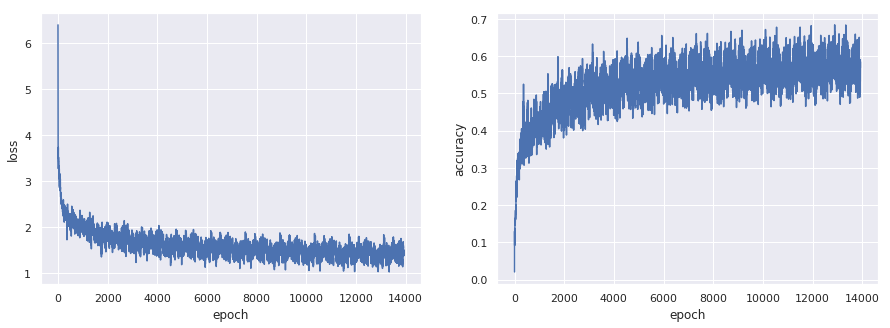

In [14]:
plt.figure(figsize = (15, 5))
plt.subplot(1, 2, 1)
EPOCH = np.arange(len(LOST))
plt.plot(EPOCH, LOST)
plt.xlabel('epoch'); plt.ylabel('loss')
plt.subplot(1, 2, 2)
plt.plot(EPOCH, ACCURACY)
plt.xlabel('epoch'); plt.ylabel('accuracy')
plt.show()

In [15]:
print(''.join([idx2char[i] for i in sess.run(model.generate)]))

<start> well.

DUKE VINCENTIO:
And therefore, you married.

ANTONDIO:
Welcome, my lord.

DUKE VINCENTIO:
I' the dukest our father.

MARIENSIO:
Well, my lord.

SEBASNNAND:
Sir, thou, sir.

DONANDIO:

ANTONOONO:
No.

SONCENSENON:
No, sir.

NONTENSIO:
Now you strange,
And with the dukes of the world and therefore.

PROSPENO:
Thou didst thou dost thou didst thou didst thou dost
And here is the duke of your father.

PETRUCHIO:
No, I'll not thing my father.

PETENCEN:
Sirrah, with the words of the world and therefore.

SEBASTIAN:
And therefore didness.

LUCENDIO:
Thou hast thou dost thou dost thou wouldst thou dost thou dost thou didst thou dost thou dost thou wouldst thou dost thou wouldst thou dost thou dost thou dost thou didst thou dost thou dost thou dost thou dost thou wouldst thou master.

SEBASTIAN:
What thou dost thou dost thou dost thou didst thou dost thou didst thou dost thou dost thou wouldst thou dost thou dost thou dost thou wouldst thou dost thou wouldst thou dost thou woulds